# Causal Inference analysis for rationales

In [130]:
import pandas as pd
import numpy as np

In [3]:
class Parameters():
    def __init__(self) -> None:
        self.control_dataset = 'code_completion_random_cut_5k_30_512_tokens'
        self.T1_dataset = 'code_completion_docstring_random_cut_3.8k_30_150_tokens'
        self.eta_results = '/workspaces/code-rationales/data/evaluation/ETA/'
        self.num_samples = 100
        self.num_trials = 30
        self.cache_dir = '/workspaces/code-rationales/datax/'
        self.save_dir = '/workspaces/code-rationales/data/evaluation/causal_analysis/'
        self.confounders_path = '/workspaces/code-rationales/semeru-datasets/semeru/galeras/code_rationales/'  # This is the galeras reference

In [58]:
args = Parameters()
control_path = '{}{}_ETA.parquet'.format(args.eta_results,args.control_dataset)
control_df = pd.read_parquet(control_path)
control_df['prompt_size'] = control_df['prompt'].apply(lambda x: len(x.split()))

In [59]:
control_df.head()

,id,commit_id,repo,path,file_name,fun_name,commit_message,code,url,language,...,from_seq_id,nl_not_semantic,nl_semantic,sc_errors,sc_nl,sc_not_semantic,sc_semantic,unknown,tag_count,prompt_size
0,159555,f9437064b3501869f5f56fb9e6d345d81ffeec5e,rasa,tests/core/test_evaluation.py,test_evaluation.py,skip_on_CI,Skip e2e tests on CI: these tests take too lon...,def skip_on_CI() -> bool:\n \n return os...,https://github.com/RasaHQ/rasa.git,Python,...,0,3.000000,18.900000,6.700000,21.200000,40.566667,87.433333,12.866667,221.666667,6
1,276430,84afc5193d38057e2e2badf9c889ea87d80d8fbf,keras,keras/tests/custom_training_loop_test.py,custom_training_loop_test.py,call,Reformatting the codebase with black.\n\nPiper...,"def call(self, inputs):\n self.add_loss...",https://github.com/keras-team/keras.git,Python,...,1,3.500000,21.400000,16.083333,21.800000,50.666667,109.000000,19.066667,261.400000,7
2,210956,39531637b5675a36409c303db022bfab90939896,PaddleDetection,deploy/python/det_keypoint_unite_infer.py,det_keypoint_unite_infer.py,smoothing_factor,one euro filter and ema smoothing for keypoint...,"def smoothing_factor(self, te, fc):\n r...",https://github.com/PaddlePaddle/PaddleDetectio...,Python,...,2,2.000000,19.600000,29.086957,19.733333,44.800000,89.366667,15.833333,243.066667,14
3,190542,4fc3616712edb19179b17dd270ad6cf63abf99c2,DeOldify,fastai/vision/image.py,image.py,data,Upgrading to support latest Pytorch version,"def data(self)->TensorImage:\n ""Return ...",https://github.com/jantic/DeOldify.git,Python,...,3,2.866667,20.100000,11.500000,24.666667,19.833333,79.466667,15.933333,206.666667,11
4,189667,e040bcacd38378386749db18aeba575b93f4ebca,manim,manim/mobject/geometry/arc.py,arc.py,stop_angle,Improved structure of the :mod:`.mobject` modu...,def stop_angle(self):\n return angle_of...,https://github.com/ManimCommunity/manim.git,Python,...,4,1.333333,22.166667,16.600000,22.400000,62.933333,109.866667,10.566667,277.166667,6


In [60]:
control_df['t_binary_treatment'] = False
control_df['t_treatment'] = 'control'

In [61]:
T1_path = '{}{}_ETA.parquet'.format(args.eta_results,args.T1_dataset)
T1_df = pd.read_parquet(T1_path)
T1_df['prompt_size'] = T1_df['prompt'].apply(lambda x: len(x.split()))

In [62]:
T1_df['t_binary_treatment'] = True
T1_df['t_treatment'] = 'T1'

In [63]:
T1_df

,id,commit_id,repo,path,file_name,fun_name,commit_message,code,url,language,...,nl_semantic,sc_errors,sc_nl,sc_not_semantic,sc_semantic,unknown,tag_count,prompt_size,t_binary_treatment,t_treatment
0,181600,388616b6247ca4ea8de4e2f340d6206aee523541,tpot,tests/driver_tests.py,driver_tests.py,test_positive_integer_or_none,"Revert ""Deployed 7ccda9a with MkDocs version: ...",def test_positive_integer_or_none():\n \n ...,https://github.com/EpistasisLab/tpot.git,Python,...,68.900000,40.178571,63.666667,74.466667,313.000000,31.666667,695.566667,26,True,T1
1,60770,f638f5d0e6c8ebed0e69a6584bc7f003ec646580,transferlearning,.venv/lib/python3.8/site-packages/pip/_interna...,base.py,get_major_minor_version,upd; format,def get_major_minor_version():\n # type: ()...,https://github.com/jindongwang/transferlearnin...,Python,...,52.900000,63.200000,64.100000,60.133333,181.433333,46.233333,522.633333,29,True,T1
2,206691,9c19aff7c7561e3a82978a272ecdaad40dda5c00,django,django/utils/http.py,http.py,urlsafe_base64_encode,Refs #33476 -- Reformatted code with Black.,def urlsafe_base64_encode(s):\n \n retur...,https://github.com/django/django.git,Python,...,67.366667,44.227273,72.400000,97.333333,240.133333,40.300000,652.300000,28,True,T1
3,219649,8198943edd73a363c266633e1aa5b2a9e9c9f526,XX-Net,python3.10.4/Lib/_pydecimal.py,_pydecimal.py,as_tuple,add python 3.10.4 for windows,def as_tuple(self):\n \n return ...,https://github.com/XX-net/XX-Net.git,Python,...,59.266667,48.966667,59.700000,92.266667,245.233333,67.800000,673.866667,27,True,T1
4,77527,0f7a365bf8bf72a4894c1ca447cf52ba67f40b0c,wagtail,wagtail/admin/widgets/chooser.py,chooser.py,get_hidden_input_context,Avoid calling super().render() in BaseChooser\...,"def get_hidden_input_context(self, name, value...",https://github.com/wagtail/wagtail.git,Python,...,68.733333,93.833333,73.066667,88.066667,242.800000,39.400000,719.866667,26,True,T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11454,a5fd192b186c66aa983137ca3a179caac7f6b786,jina,jina/hubble/hubapi.py,hubapi.py,list_local,feat: optimize create hub root (#4388),def list_local():\n \n result = []\n ...,https://github.com/jina-ai/jina.git,Python,...,67.366667,38.125000,62.400000,110.600000,362.133333,113.033333,830.566667,31,True,T1
96,300860,8f4caf414124f380a8f5e1d54aedb54a8f6c5c05,core,homeassistant/components/alexa/state_report.py,state_report.py,async_enable_proactive_mode,Clean up accessing event helpers via hass (#72...,"async def async_enable_proactive_mode(hass, sm...",https://github.com/home-assistant/core.git,Python,...,75.966667,54.333333,69.366667,68.900000,269.166667,64.766667,683.433333,35,True,T1
97,314450,10dc38e0ec27f7bef990ee431459342f9c3c52b4,core,homeassistant/components/motion_blinds/cover.py,cover.py,current_cover_position,Adjust CoverEntity property type hints in comp...,def current_cover_position(self) -> int | None...,https://github.com/home-assistant/core.git,Python,...,65.633333,35.633333,61.433333,87.500000,193.900000,64.900000,607.433333,33,True,T1
98,63723,f638f5d0e6c8ebed0e69a6584bc7f003ec646580,transferlearning,.venv/lib/python3.8/site-packages/pip/_vendor/...,structs.py,connect,upd; format,"def connect(self, f, t):\n \n if...",https://github.com/jindongwang/transferlearnin...,Python,...,63.966667,30.960000,55.466667,95.200000,352.600000,83.500000,763.366667,33,True,T1


In [189]:
treatments_df = pd.concat([control_df,T1_df], axis=0)

In [190]:
treatments_df['n_ast_errors']

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: n_ast_errors, Length: 200, dtype: int64

In [66]:
treatments_df.describe()

,id,n_ast_errors,ast_levels,n_whitespaces,n_words,vocab_size,complexity,nloc,token_counts,n_ast_nodes,...,from_seq_id,nl_not_semantic,nl_semantic,sc_errors,sc_nl,sc_not_semantic,sc_semantic,unknown,tag_count,prompt_size
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,197.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,171001.355000,0.03500,9.515000,35.710000,12.365000,11.245000,1.560000,6.445000,36.450000,49.890000,...,49.500000,8.099640,43.438500,33.147084,42.973500,60.131500,198.052833,42.124167,480.565167,19.39500
std,94475.034198,0.20975,1.994912,26.950092,7.652094,6.047964,1.290242,7.706095,38.892294,25.613633,...,28.938507,6.596477,23.120386,20.026276,20.563436,37.680521,121.267033,35.121851,261.632276,14.56122
min,284.000000,0.00000,5.000000,4.000000,3.000000,3.000000,1.000000,2.000000,8.000000,17.000000,...,0.000000,1.000000,15.700000,6.458333,16.966667,12.900000,51.566667,3.766667,169.800000,2.00000
25%,91532.500000,0.00000,8.000000,18.000000,7.000000,7.000000,1.000000,3.000000,18.000000,31.000000,...,24.750000,2.100000,20.916667,17.191667,22.491667,26.258333,89.325000,16.991667,226.441667,5.75000
50%,181270.500000,0.00000,9.000000,25.000000,10.000000,9.000000,1.000000,4.000000,24.000000,41.000000,...,49.500000,6.333333,37.100000,27.522807,46.300000,56.683333,142.783333,31.566667,393.033333,18.00000
75%,258253.000000,0.00000,11.000000,51.000000,16.000000,15.000000,2.000000,7.000000,40.250000,64.000000,...,74.250000,13.100000,65.700000,47.288571,62.525000,88.883333,311.800000,51.641667,739.666667,31.00000
max,334797.000000,2.00000,17.000000,139.000000,41.000000,32.000000,11.000000,75.000000,335.000000,138.000000,...,99.000000,28.200000,86.233333,93.833333,82.300000,237.600000,487.600000,188.633333,976.200000,57.00000


In [67]:
columns_array = treatments_df.columns.to_numpy()

In [68]:
columns_array

array(['id', 'commit_id', 'repo', 'path', 'file_name', 'fun_name',
       'commit_message', 'code', 'url', 'language', 'ast_errors',
       'n_ast_errors', 'ast_levels', 'n_whitespaces', 'n_words',
       'vocab_size', 'complexity', 'nloc', 'token_counts', 'n_ast_nodes',
       'n_identifiers', 'signature', 'prompt', 'from_seq_id',
       'nl_not_semantic', 'nl_semantic', 'sc_errors', 'sc_nl',
       'sc_not_semantic', 'sc_semantic', 'unknown', 'tag_count',
       'prompt_size', 't_binary_treatment', 't_treatment', 'docstring',
       'random_cut'], dtype=object)

In [69]:
selected_columns = ['n_ast_errors', 'ast_levels', 'n_whitespaces', 'n_words',
       'vocab_size', 'complexity', 'nloc', 'token_counts', 'n_ast_nodes',
       'n_identifiers','t_binary_treatment', 't_treatment','prompt_size']
#[ 'sc_errors', 'sc_not_semantic', 'sc_semantic', 'unknown', 'tag_count', 'docstring', 'random_cut']
      

In [70]:
selected_columns.append('sc_errors')

In [71]:
errors_df = treatments_df[selected_columns]

In [72]:
errors_df.fillna(0)

,n_ast_errors,ast_levels,n_whitespaces,n_words,vocab_size,complexity,nloc,token_counts,n_ast_nodes,n_identifiers,t_binary_treatment,t_treatment,prompt_size,sc_errors
0,0,9,18,12,12,1,3,28,55,5,False,control,6,6.700000
1,0,9,21,8,8,1,3,24,38,7,False,control,7,16.083333
2,0,10,36,19,16,1,3,28,42,7,False,control,14,29.086957
3,0,6,24,11,11,1,3,12,22,4,False,control,11,11.500000
4,0,11,14,8,8,1,2,24,39,6,False,control,6,16.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,9,31,12,11,2,5,30,53,6,True,T1,31,38.125000
96,0,8,22,13,13,1,7,41,28,4,True,T1,35,54.333333
97,0,8,48,16,13,2,9,29,48,5,True,T1,33,35.633333
98,0,9,52,13,13,2,5,45,71,9,True,T1,33,30.960000


In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='n_ast_errors', ylabel='Count'>

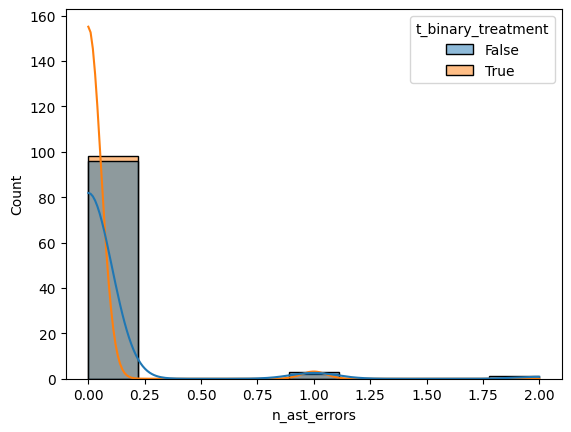

In [474]:
sns.histplot(data=treatments_df, x="n_ast_errors", kde=True, hue="t_binary_treatment")

In [475]:
treatments_df['n_ast_errors'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

<AxesSubplot:xlabel='sc_semantic', ylabel='Count'>

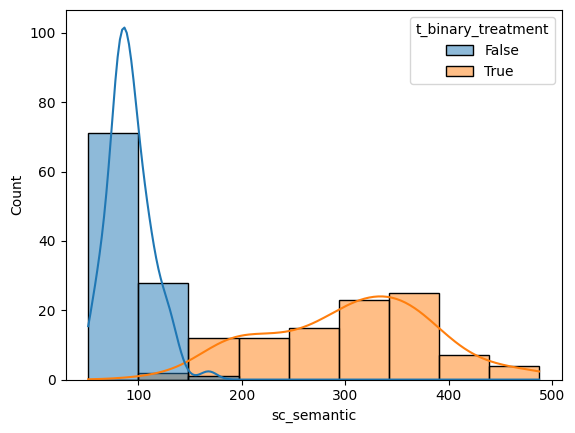

In [284]:
sns.histplot(data=treatments_df, x="sc_semantic", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='prompt_size', ylabel='Count'>

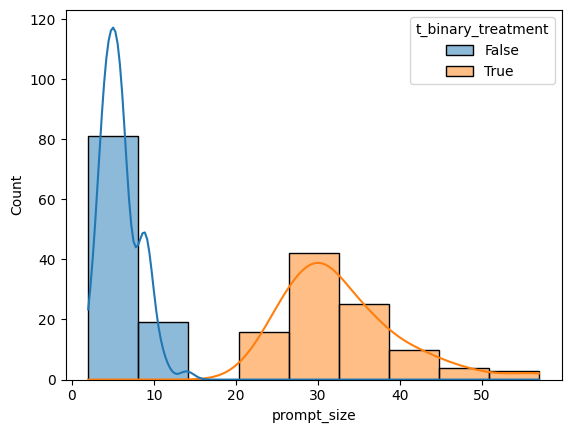

In [285]:
sns.histplot(data=treatments_df, x="prompt_size", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='ast_levels', ylabel='Count'>

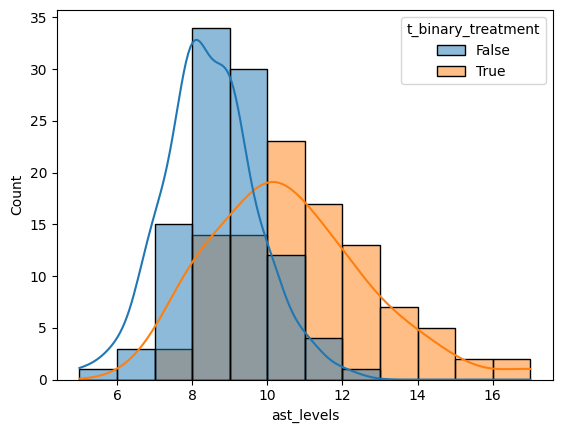

In [286]:
sns.histplot(data=treatments_df, x="ast_levels", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='n_ast_nodes', ylabel='Count'>

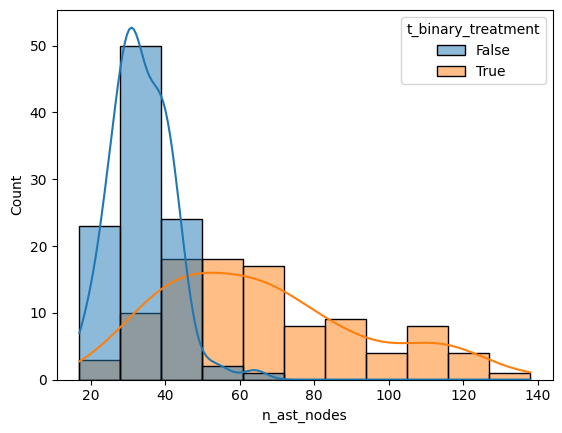

In [287]:
sns.histplot(data=treatments_df, x="n_ast_nodes", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='vocab_size', ylabel='Count'>

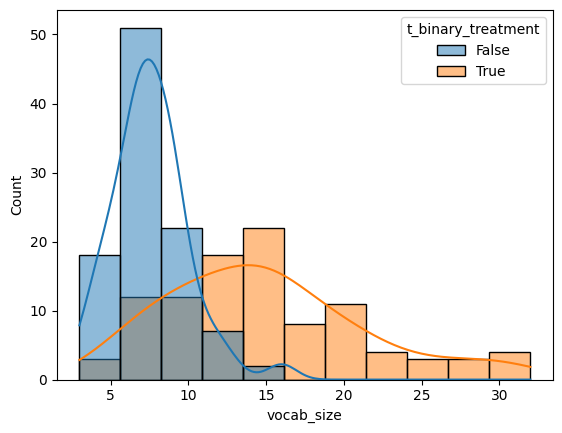

In [288]:
sns.histplot(data=treatments_df, x="vocab_size", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='complexity', ylabel='Count'>

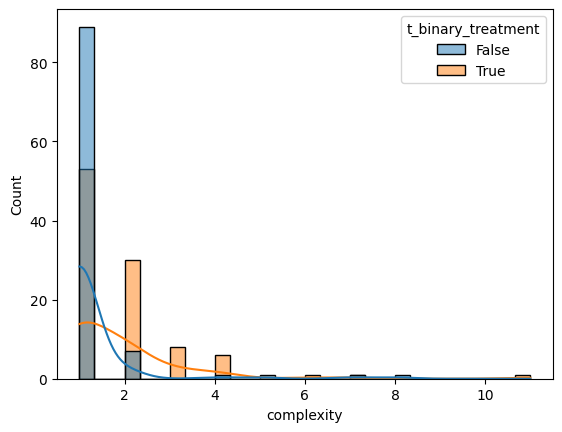

In [289]:
sns.histplot(data=treatments_df, x="complexity", kde=True, hue="t_binary_treatment")

<AxesSubplot:xlabel='nloc', ylabel='Count'>

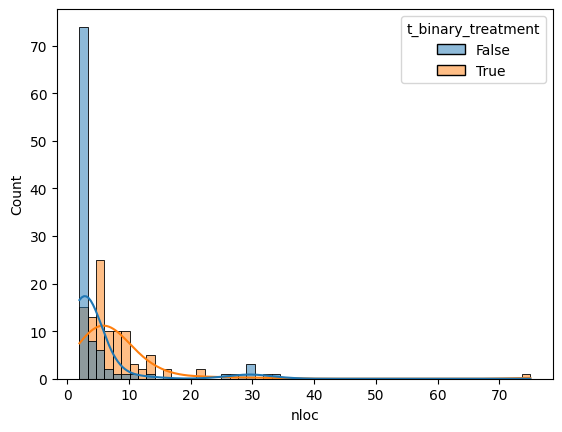

In [290]:
sns.histplot(data=treatments_df, x="nloc", kde=True, hue="t_binary_treatment")

ValueError: cannot reindex from a duplicate axis

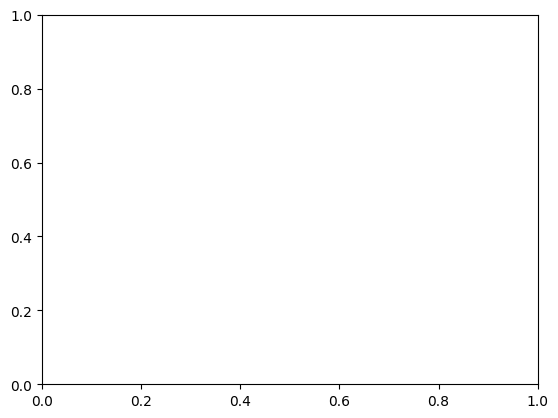

In [449]:
sns.histplot(data=treatments_df, x="nl_not_semantic", kde=True, hue="t_binary_treatment") 

In [453]:
treatments_df['nl_not_semantic']= treatments_df['nl_not_semantic'].fillna(0)

In [291]:
from scipy import stats


In [292]:
stats.pearsonr(treatments_df['sc_semantic'].values, treatments_df['prompt_size'].values)

PearsonRResult(statistic=0.8582203588982381, pvalue=2.9449949518036477e-59)

In [293]:
stats.pearsonr(treatments_df['sc_semantic'].values, treatments_df['n_ast_nodes'].values)

PearsonRResult(statistic=0.7183331351742612, pvalue=4.945256736133423e-33)

In [294]:
stats.pearsonr(treatments_df['sc_semantic'].values, treatments_df['vocab_size'].values)

PearsonRResult(statistic=0.5951556290132225, pvalue=1.4913530537327584e-20)

In [295]:
stats.pearsonr(treatments_df['sc_semantic'].values, treatments_df['ast_levels'].values)

PearsonRResult(statistic=0.608428553076114, pvalue=1.2226324919792925e-21)

In [298]:
stats.pearsonr(treatments_df['sc_semantic'].values, treatments_df['nloc'].values)

PearsonRResult(statistic=0.18025154557746456, pvalue=0.010645693548933528)

## I. Create a causal model from the data and given graph.

In [20]:
from dowhy import CausalModel

In [454]:
model_sc_errors = CausalModel(
        data = treatments_df,
        treatment = ['t_binary_treatment'],
        outcome = ['nl_not_semantic'],
        effect_modifiers = ['ast_levels'], 
        instruments = ['vocab_size'],
        common_causes= [ 'prompt_size', 'n_ast_nodes']
        #common_causes= [ 'n_ast_errors']
    )

In [455]:
identified_estimand = model_sc_errors.identify_effect(proceed_when_unidentifiable=False)

In [456]:
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                      
─────────────────────(E[nl_not_semantic|prompt_size,n_ast_nodes])
d[t_binary_treatment]                                            
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→nl_not_semantic then P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes,U) = P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                    -1⎤
 ⎢      d                        ⎛      d                            ⎞  ⎥
E⎢─────────────(nl_not_semantic)⋅⎜─────────────([t_binary_treatment])⎟  ⎥
 ⎣d[vocab_size]                  ⎝d[vocab_size]                      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→nl_not_semantic then ¬(U →→{vocab_size})
Estimand assumption 2, Exclusion: 

# III. Estimate the target estimand using a statistical method.


In [457]:
causal_estimate_match_sc_errors = model_sc_errors.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_weighting") #"backdoor.propensity_score_stratification"

In [458]:
print(causal_estimate_match_sc_errors)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                      
─────────────────────(E[nl_not_semantic|prompt_size,n_ast_nodes])
d[t_binary_treatment]                                            
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→nl_not_semantic then P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes,U) = P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes)

## Realized estimand
b: nl_not_semantic~t_binary_treatment+prompt_size+n_ast_nodes
Target units: ate

## Estimate
Mean value: 11.34904178162176



In [459]:
print("Causal Estimate is " + str(causal_estimate_match_sc_errors.value))

#print("ATE", np.mean(T1_df["sc_errors"])- np.mean(control_df["sc_errors"]))

Causal Estimate is 11.34904178162176


# IV. Refute the obtained estimate using multiple robustness checks.

In [460]:

es_placebo_sc_error = model_sc_errors.refute_estimate(
                identified_estimand,
                causal_estimate_match_sc_errors,
                method_name="placebo_treatment_refuter",
                placebo_type="permute",
                num_simulations=20
        )

In [461]:
print(es_placebo_sc_error)

Refute: Use a Placebo Treatment
Estimated effect:11.34904178162176
New effect:-10.239669446299322
p value:0.0



In [462]:
refute_common_cause_sc_error = model_sc_errors.refute_estimate(identified_estimand, causal_estimate_match_sc_errors,
                                       method_name="random_common_cause")

In [463]:
print(refute_common_cause_sc_error)

Refute: Add a random common cause
Estimated effect:11.34904178162176
New effect:11.34904178162176
p value:1.0



In [464]:
refute_common_cause_sc_error =model_sc_errors.refute_estimate(identified_estimand, causal_estimate_match_sc_errors,
        method_name="data_subset_refuter", subset_fraction=0.9)

In [465]:
print(refute_common_cause_sc_error)

Refute: Use a subset of data
Estimated effect:11.34904178162176
New effect:11.365017226409766
p value:0.8600000000000001



## V. Using additional estimands

In [466]:
causal_estimate_match_sc_errors_matching = model_sc_errors.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_matching")

In [467]:
print(causal_estimate_match_sc_errors_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                      
─────────────────────(E[nl_not_semantic|prompt_size,n_ast_nodes])
d[t_binary_treatment]                                            
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→nl_not_semantic then P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes,U) = P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes)

## Realized estimand
b: nl_not_semantic~t_binary_treatment+prompt_size+n_ast_nodes
Target units: ate

## Estimate
Mean value: 13.27452089081088



In [468]:
es_placebo = model_sc_errors.refute_estimate(
                identified_estimand,
                causal_estimate_match_sc_errors_matching,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

In [469]:
print(es_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.27452089081088
New effect:-0.28129403700107
p value:0.86



In [470]:

refute_common_cause = model_sc_errors.refute_estimate(identified_estimand, causal_estimate_match_sc_errors_matching,
                                       method_name="random_common_cause")

In [471]:
print(refute_common_cause)

Refute: Add a random common cause
Estimated effect:13.27452089081088
New effect:13.274520890810882
p value:1.0



In [472]:
res_subset =model_sc_errors.refute_estimate(identified_estimand, causal_estimate_match_sc_errors_matching,
        method_name="data_subset_refuter", subset_fraction=0.9)

In [473]:
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.27452089081088
New effect:11.483108182193835
p value:0.58



## VI Using stratification

In [188]:
causal_estimate_match = model_sc_errors.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_stratification") #"backdoor.propensity_score_stratification"

/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["strata"] = ((data[self.propensity_score_column].rank(ascending=True) / num_rows) * num_strata).round(0)
/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dbar"] = 1 - data[self._target_estimand.treatment_variable[0]]  # 1-Treatment


ValueError: Not enough data to generate at least two strata. This error may be due to a high value of 'clipping_threshold'.

In [369]:
outcomes = ['nl_not_semantic', 'nl_semantic', 'sc_errors', 'sc_nl',
       'sc_not_semantic', 'sc_semantic', 'unknown', 'tag_count']
results = list()
methods = ['backdoor.propensity_score_weighting', 'backdoor.propensity_score_matching' ]
for outcome in outcomes:
    model = CausalModel(
        data = treatments_df,
        treatment = ['t_binary_treatment'],
        outcome = [outcome],
        effect_modifiers = ['ast_levels'], 
        instruments = ['vocab_size'],
        common_causes= [ 'prompt_size', 'n_ast_nodes']
        #common_causes= [ 'n_ast_errors']
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print(identified_estimand)
    ate = np.mean(T1_df[outcome])- np.mean(control_df[outcome])
    print("ATE",ate )
    estimators_result = []
    for method in methods:
        print('------Estimate ---- ' + method )
        causal_estimate = model.estimate_effect(identified_estimand,method_name=method)
        print('----Robustness checks-----')
        es_placebo = model.refute_estimate(
                identified_estimand,
                causal_estimate,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )
        print(es_placebo)
        refute_common = model.refute_estimate(identified_estimand, causal_estimate,
                                   method_name="random_common_cause")
        print(refute_common)
        refute_subset =model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
        print(refute_subset)
        estimators_result.append({'method':method, 'placebo_treatment':str(es_placebo),'random_common_cause':str(refute_common),'data_subset_refuter':str(refute_subset)})
    results.append({'outcome': outcome, 'estimand': str(identified_estimand), 'ate': ate, 'refuters':estimators_result})
results
       
    

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                      
─────────────────────(E[nl_not_semantic|prompt_size,n_ast_nodes])
d[t_binary_treatment]                                            
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→nl_not_semantic then P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes,U) = P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                    -1⎤
 ⎢      d                        ⎛      d                            ⎞  ⎥
E⎢─────────────(nl_not_semantic)⋅⎜─────────────([t_binary_treatment])⎟  ⎥
 ⎣d[vocab_size]                  ⎝d[vocab_size]                      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→nl_not_semantic then ¬(U →→{vocab_size})
Estimand assumption 2, Exclusion: 

[{'outcome': 'nl_not_semantic',
  'estimand': 'Estimand type: EstimandType.NONPARAMETRIC_ATE\n\n### Estimand : 1\nEstimand name: backdoor\nEstimand expression:\n          d                                                      \n─────────────────────(E[nl_not_semantic|prompt_size,n_ast_nodes])\nd[t_binary_treatment]                                            \nEstimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→nl_not_semantic then P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes,U) = P(nl_not_semantic|t_binary_treatment,prompt_size,n_ast_nodes)\n\n### Estimand : 2\nEstimand name: iv\nEstimand expression:\n ⎡                                                                    -1⎤\n ⎢      d                        ⎛      d                            ⎞  ⎥\nE⎢─────────────(nl_not_semantic)⋅⎜─────────────([t_binary_treatment])⎟  ⎥\n ⎣d[vocab_size]                  ⎝d[vocab_size]                      ⎠  ⎦\nEstimand assumption 1, As-if-random: If U→→nl_not_sema

In [378]:
results[8]

IndexError: list index out of range